In [2]:
# Imports + file list + load
import pandas as pd
import numpy as np
from pathlib import Path

files = {
    "Barcelona": "Barcelona_clean_hourly.csv",
    "Beijing": "Beijing_clean_hourly.csv",
    "Delhi":   "Delhi_clean_hourly.csv",
    "Dhaka":  "Dhaka_clean_hourly.csv",
    "London":  "London_clean_hourly.csv",
    "Madrid":  "Madrid_clean_hourly.csv",
    "Moscow":  "Moscow_clean_hourly.csv",
    "Paris": "Paris_clean_hourly.csv",
    "Shanghai": "Shanghai_clean_hourly.csv",
    "Tokyo": "Tokyo_clean_hourly.csv",
}

dfs = []
for city, fn in files.items():
    p = Path(fn)
    if not p.exists():
        print(f"Warning: {fn} not found, skipping {city}.")
        continue
    df = pd.read_csv(p, parse_dates=["datetime"] if "datetime" in pd.read_csv(p, nrows=0).columns else [])
    df = df.copy()
    df["city"] = city
    dfs.append(df)

if not dfs:
    raise RuntimeError("No files loaded. Check filenames and working directory.")
combined = pd.concat(dfs, ignore_index=True)
print("Loaded combined shape:", combined.shape)
combined.head()


Loaded combined shape: (438720, 14)


,datetime,date,pm10,pm2_5,carbon_monoxide,carbon_dioxide,nitrogen_dioxide,sulphur_dioxide,ozone,ammonia,methane,missing_pollutants,city,n_missing_pollutants
0,2020-01-01 00:00:00+00:00,2020-01-01 00:00:00+00:00,21.1,23.5,263.0,NaN,21.3,3.0,16.0,3.1,NaN,2.0,Barcelona,NaN
1,2020-01-01 01:00:00+00:00,2020-01-01 01:00:00+00:00,22.8,21.0,251.0,NaN,31.9,3.0,11.0,2.7,NaN,2.0,Barcelona,NaN
2,2020-01-01 02:00:00+00:00,2020-01-01 02:00:00+00:00,23.6,24.0,240.0,NaN,33.1,3.2,14.0,2.5,NaN,2.0,Barcelona,NaN
3,2020-01-01 03:00:00+00:00,2020-01-01 03:00:00+00:00,21.8,19.8,227.0,NaN,26.8,1.9,15.0,2.4,NaN,2.0,Barcelona,NaN
4,2020-01-01 04:00:00+00:00,2020-01-01 04:00:00+00:00,21.0,16.3,228.0,NaN,29.6,2.5,9.0,2.9,NaN,2.0,Barcelona,NaN


In [3]:
# Canonical pollutant detection and normalize column names
# canonical names we will use
canonical = ["pm10","pm2_5","ammonia","carbon_monoxide",
             "nitrogen_dioxide","carbon_dioxide","sulphur_dioxide","methane"]

# normalize combined column names to lowercase/no spaces/dots
combined.columns = [c.strip().lower().replace(" ", "_").replace(".", "_") for c in combined.columns]

# build mapping for common pm2.5 variants
col_map = {}
for c in combined.columns:
    c_norm = c.lower()
    if c_norm in canonical:
        col_map[c] = c_norm
    # handle pm2.5 / pm25 variants
    elif c_norm.replace(".", "_") in canonical:
        col_map[c] = c_norm.replace(".", "_")
    elif c_norm.replace(".", "") in [x.replace("_","") for x in canonical]:
        # e.g., pm25 -> pm2_5
        for p in canonical:
            if c_norm.replace(".","").replace("_","") == p.replace("_",""):
                col_map[c] = p

if col_map:
    combined = combined.rename(columns=col_map)

# final pollutant list available
pollutants = [p for p in canonical if p in combined.columns]
print("Detected pollutant columns:", pollutants)
if not pollutants:
    raise RuntimeError("No pollutant columns found. Check file columns.")


Detected pollutant columns: ['pm10', 'pm2_5', 'ammonia', 'carbon_monoxide', 'nitrogen_dioxide', 'carbon_dioxide', 'sulphur_dioxide', 'methane']


In [4]:
# Drop totally missing pollutants and quick missing diagnostics
# drop pollutants that are NaN across the entire combined dataset
all_nan = [p for p in pollutants if combined[p].isna().all()]
if all_nan:
    print("Dropping all-NaN pollutants:", all_nan)
    combined = combined.drop(columns=all_nan)
    pollutants = [p for p in pollutants if p not in all_nan]

# show missing counts / fraction
miss_cnt = combined[pollutants].isna().sum()
miss_pct = 100 * miss_cnt / len(combined)
missing_df = pd.DataFrame({"missing_count": miss_cnt, "missing_pct": miss_pct.round(2)})
display(missing_df.sort_values("missing_pct", ascending=False))


,missing_count,missing_pct
methane,422340,96.27
carbon_dioxide,422340,96.27
ammonia,219360,50.00
pm10,113490,25.87
carbon_monoxide,113490,25.87
pm2_5,113490,25.87
nitrogen_dioxide,113490,25.87
sulphur_dioxide,113490,25.87


In [5]:
# Imputation (KNN) and scaling
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler

X = combined[pollutants].copy()

USE_KNN = True  # set False to use SimpleImputer(mean)

if USE_KNN:
    # scale temporarily on median-filled data to get good neighbor distances
    X_temp = X.fillna(X.median())
    tmp_scaler = StandardScaler()
    X_temp_scaled = tmp_scaler.fit_transform(X_temp)

    knn = KNNImputer(n_neighbors=5, weights="uniform")
    X_knn_scaled = knn.fit_transform(X_temp_scaled)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_knn_scaled)
else:
    imputer = SimpleImputer(strategy="mean")
    X_imp = imputer.fit_transform(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imp)

print("Imputation + scaling done. Any NaNs left:", np.isnan(X_scaled).any())


Imputation + scaling done. Any NaNs left: False


Explained variance ratio (first components): [0.505 0.183 0.13 ]


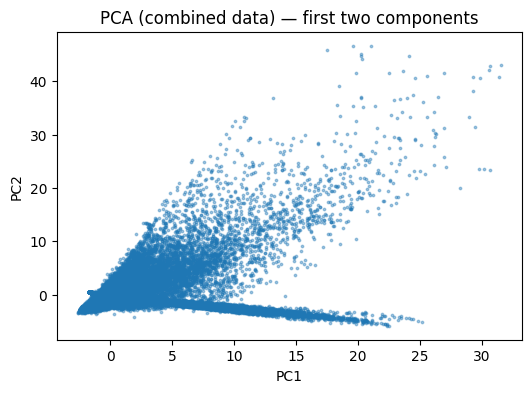

In [6]:
# PCA (for speed and visualization)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

DO_PCA = True
PCA_N = 3

if DO_PCA:
    pca = PCA(n_components=PCA_N, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    print("Explained variance ratio (first components):", np.round(pca.explained_variance_ratio_, 3))

    plt.figure(figsize=(6,4))
    if PCA_N >= 2:
        plt.scatter(X_pca[:,0], X_pca[:,1], s=3, alpha=0.4)
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title("PCA (combined data) — first two components")
    else:
        plt.plot(X_pca[:,0], ".", ms=1)
    plt.show()
else:
    X_pca = X_scaled

k=2, inertia=431016.84
k=3, inertia=371473.76
k=4, inertia=280309.84
k=5, inertia=249039.04
k=6, inertia=252329.65
k=7, inertia=226709.34
k=8, inertia=142557.01


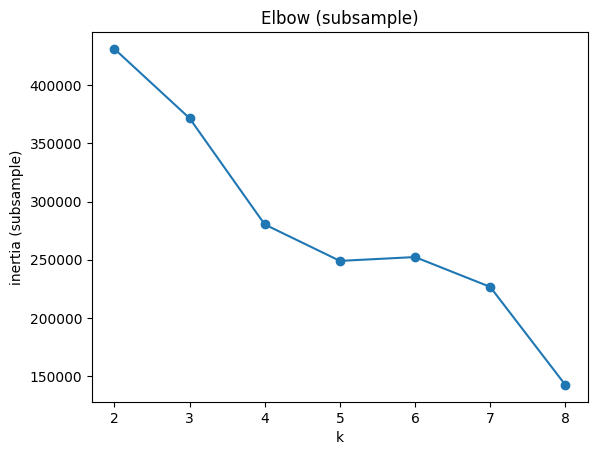

In [7]:
# fast elbow (subsample) using MiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

X_for_elbow = X_pca  # fast
frac = 0.25
rng = np.random.RandomState(42)
n_sample = max(2000, int(len(X_for_elbow)*frac))
idx = rng.choice(len(X_for_elbow), size=n_sample, replace=False)
X_sample = X_for_elbow[idx]

Ks = range(2,9)
inertias = []
for k in Ks:
    mb = MiniBatchKMeans(n_clusters=k, batch_size=2048, random_state=42, max_iter=200, n_init=3)
    mb.fit(X_sample)
    inertias.append(mb.inertia_)
    print(f"k={k}, inertia={mb.inertia_:.2f}")

plt.plot(list(Ks), inertias, marker='o')
plt.xlabel("k")
plt.ylabel("inertia (subsample)")
plt.title("Elbow (subsample)")
plt.show()


In [8]:
# Final clustering on data
from sklearn.cluster import MiniBatchKMeans

k_final = 4
CLUSTER_ON_PCA = True  # True-> use X_pca; False-> use X_scaled

X_final = X_pca if CLUSTER_ON_PCA else X_scaled

model = MiniBatchKMeans(n_clusters=k_final, batch_size=2048, random_state=42, max_iter=300, n_init=5)
labels = model.fit_predict(X_final)
combined["cluster"] = labels

# save full results
combined.to_csv("global_clusters_all_cities.csv", index=False)
print("Saved global_clusters_all_cities.csv")
print("Cluster counts:")
print(combined["cluster"].value_counts().sort_index())


Saved global_clusters_all_cities.csv
Cluster counts:
cluster
0     35338
1     36863
2     97080
3    269439
Name: count, dtype: int64


Random Cluster Metric Testing

In [9]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
import numpy as np

rng = np.random.RandomState(42)
sample_size = 10000
idx = rng.choice(len(X_pca), size=sample_size, replace=False)

X_sample = X_pca[idx]

results = []

for k in [3, 4]:
    model = MiniBatchKMeans(
        n_clusters=k,
        batch_size=2048,
        random_state=42,
        max_iter=300,
        n_init=5
    )

    labels_k = model.fit_predict(X_sample)

    sil = silhouette_score(X_sample, labels_k)
    dbi = davies_bouldin_score(X_sample, labels_k)
    ch  = calinski_harabasz_score(X_sample, labels_k)

    results.append((k, sil, dbi, ch))

for k, sil, dbi, ch in results:
    print(
        f"k={k} | "
        f"Silhouette={sil:.3f} | "
        f"Davies–Bouldin={dbi:.3f} | "
        f"Calinski–Harabasz={ch:.1f}"
    )

k=3 | Silhouette=0.508 | Davies–Bouldin=1.100 | Calinski–Harabasz=4611.0
k=4 | Silhouette=0.621 | Davies–Bouldin=0.889 | Calinski–Harabasz=4727.5


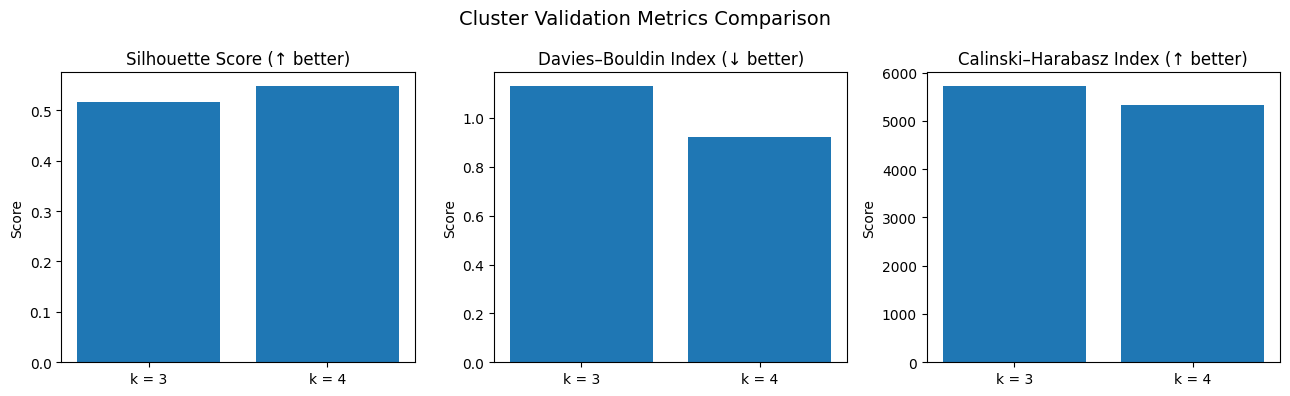

In [10]:
import matplotlib.pyplot as plt

# Metric values from results
ks = ["k = 3", "k = 4"]

silhouette_scores = [0.517, 0.548]
davies_bouldin_scores = [1.130, 0.921]
calinski_harabasz_scores = [5718.2, 5323.5]

# Figures
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Silhouette
axes[0].bar(ks, silhouette_scores)
axes[0].set_title("Silhouette Score (↑ better)")
axes[0].set_ylabel("Score")

# Davies Bouldin
axes[1].bar(ks, davies_bouldin_scores)
axes[1].set_title("Davies–Bouldin Index (↓ better)")
axes[1].set_ylabel("Score")

# Calinski Harabasz
axes[2].bar(ks, calinski_harabasz_scores)
axes[2].set_title("Calinski–Harabasz Index (↑ better)")
axes[2].set_ylabel("Score")

# Layout
plt.suptitle("Cluster Validation Metrics Comparison", fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
# Cluster profiles and city + cluster distribution + percentage distribution
polls = [p for p in pollutants if p in combined.columns]
cluster_profiles = combined.groupby("cluster")[polls].mean().round(3)
city_cluster_counts = combined.groupby(["city","cluster"]).size().unstack(fill_value=0)
city_cluster_pct = city_cluster_counts.div(city_cluster_counts.sum(axis=1), axis=0).multiply(100).round(2)

cluster_profiles.to_csv("global_cluster_profiles.csv")
city_cluster_counts.to_csv("city_cluster_counts.csv")
city_cluster_pct.to_csv("city_cluster_pct.csv")

print("Cluster profiles (means):")
display(cluster_profiles)
print("City x Cluster counts:")
display(city_cluster_counts)
print("City x Cluster % distribution:")
display(city_cluster_pct)

Cluster profiles (means):


,pm10,pm2_5,ammonia,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane
cluster,,,,,,,,
0,27.921,20.429,5.831,281.016,41.345,508.316,10.025,1667.449
1,142.053,97.273,4.337,1777.425,79.581,524.431,83.890,2200.403
2,45.299,29.504,1.515,398.041,42.443,471.796,25.271,1596.353
3,14.046,8.739,1.592,179.011,17.133,460.010,3.919,1449.259


City x Cluster counts:


cluster,0,1,2,3
city,,,,
Barcelona,15968,0,2935,24969
Beijing,0,11679,7722,24471
Delhi,0,9005,11784,23083
Dhaka,0,4774,10712,28386
London,5522,2,1863,36485
Madrid,2208,13,5571,36080
Moscow,3786,1611,27360,11115
Paris,7853,54,3205,32760
Shanghai,0,7495,11917,24460


City x Cluster % distribution:


cluster,0,1,2,3
city,,,,
Barcelona,36.40,0.00,6.69,56.91
Beijing,0.00,26.62,17.60,55.78
Delhi,0.00,20.53,26.86,52.61
Dhaka,0.00,10.88,24.42,64.70
London,12.59,0.00,4.25,83.16
Madrid,5.03,0.03,12.70,82.24
Moscow,8.63,3.67,62.36,25.34
Paris,17.90,0.12,7.31,74.67
Shanghai,0.00,17.08,27.16,55.75


In [12]:
# Asia vs Europe
asia = ["Jakarta","Bangkok","Tokyo"]
europe = ["Berlin","London","Moscow"]

combined["region"] = combined["city"].apply(lambda x: "Asia" if x in asia else "Europe")
region_profile = combined.groupby("region")[polls].mean().round(3)
region_profile.to_csv("region_profile_asia_vs_europe.csv")

print("Region mean pollutant table (Asia vs Europe):")
display(region_profile)

# Quick difference (Asia - Europe)
diff = (region_profile.loc["Asia"] - region_profile.loc["Europe"]).round(3)
print("Asia minus Europe (positive => higher in Asia):")
display(diff)

Region mean pollutant table (Asia vs Europe):


,pm10,pm2_5,ammonia,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane
region,,,,,,,,
Asia,36.084,24.434,NaN,327.113,53.103,495.726,31.758,1473.307
Europe,39.622,26.368,2.281,444.273,33.094,486.804,19.203,1773.141


Asia minus Europe (positive => higher in Asia):


,0
pm10,-3.538
pm2_5,-1.934
ammonia,NaN
carbon_monoxide,-117.160
nitrogen_dioxide,20.009
carbon_dioxide,8.922
sulphur_dioxide,12.555
methane,-299.834


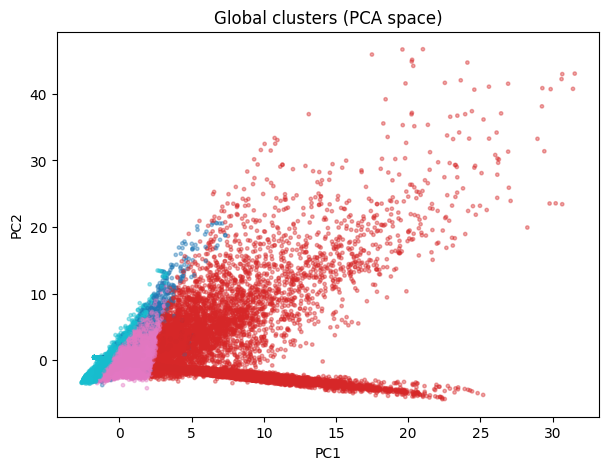

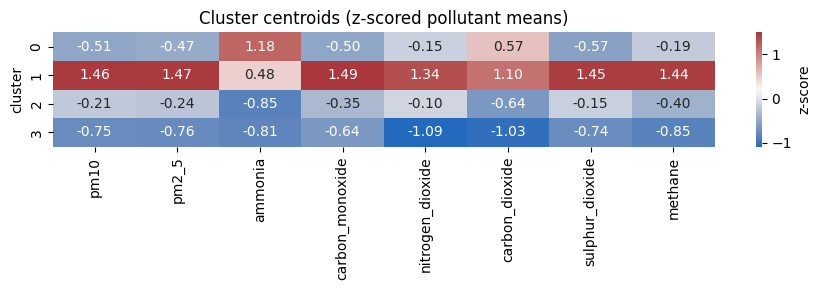

In [13]:
# PCA scatter + heatmap of cluster centroids
import matplotlib.pyplot as plt
import seaborn as sns

# PCA scatter
if CLUSTER_ON_PCA:
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=6, cmap="tab10", alpha=0.4)
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("Global clusters (PCA space)")
    plt.show()

# heatmap of z-scored cluster profiles for readability
z = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()
plt.figure(figsize=(9,3))
sns.heatmap(z, annot=True, fmt=".2f", cmap="vlag", cbar_kws={"label":"z-score"})
plt.title("Cluster centroids (z-scored pollutant means)")
plt.ylabel("cluster")
plt.tight_layout()
plt.show()

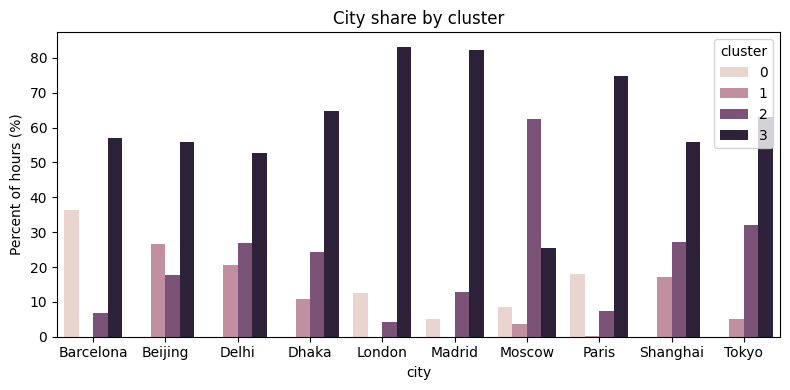

/tmp/ipython-input-3516133977.py:14: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly = combined.groupby([combined["datetime"].dt.to_period("M"), "cluster"]).size().unstack(fill_value=0)


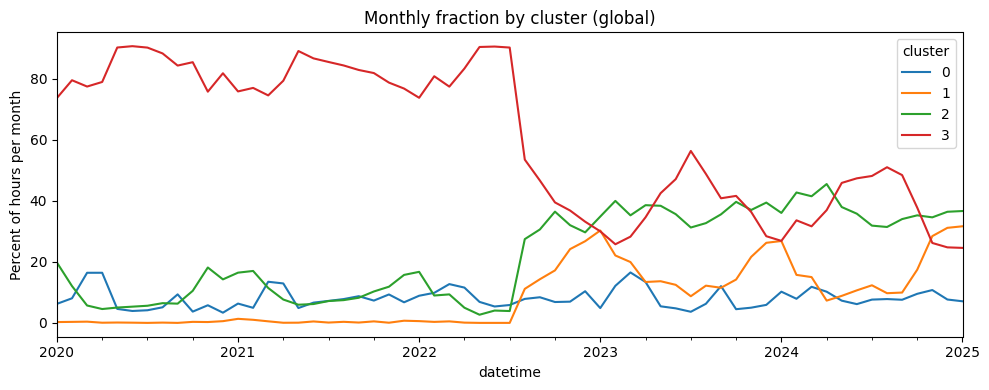

In [20]:
# Temporal and city analysis examples
# Fraction of hours by cluster per city (bar chart)
# city_cluster_pct = city_cluster_pct.reset_index().melt(id_vars="city", var_name="cluster", value_name="pct")
plt.figure(figsize=(8,4))
sns.barplot(data=city_cluster_pct, x="city", y="pct", hue="cluster")
plt.ylabel("Percent of hours (%)")
plt.title("City share by cluster")
plt.legend(title="cluster")
plt.tight_layout()
plt.show()

# Monthly frequency of one cluster (example)
combined["datetime"] = pd.to_datetime(combined["datetime"])
monthly = combined.groupby([combined["datetime"].dt.to_period("M"), "cluster"]).size().unstack(fill_value=0)
monthly_frac = monthly.div(monthly.sum(axis=1), axis=0).multiply(100)
monthly_frac.plot(kind="line", figsize=(10,4))
plt.ylabel("Percent of hours per month")
plt.title("Monthly fraction by cluster (global)")
plt.legend(title="cluster")
plt.tight_layout()
plt.show()

CLUSTERING PROCESS (HIERARCHICAL CLUSTERING)

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

In [22]:
# Asia
tokyo = pd.read_csv("Tokyo_clean_hourly.csv")
shanghai = pd.read_csv("Shanghai_clean_hourly.csv")
dhaka = pd.read_csv("Dhaka_clean_hourly.csv")
delhi = pd.read_csv("Delhi_clean_hourly.csv")
beijing = pd.read_csv("Beijing_clean_hourly.csv")

# Europe
paris = pd.read_csv("Paris_clean_hourly.csv")
barcelona = pd.read_csv("Barcelona_clean_hourly.csv")
madrid = pd.read_csv("Madrid_clean_hourly.csv")
london = pd.read_csv("London_clean_hourly.csv")
moscow = pd.read_csv("Moscow_clean_hourly.csv")

# Add city names
tokyo["city"] = "Tokyo"
shanghai["city"] = "Shanghai"
dhaka["city"] = "Dhaka"
delhi["city"] = "Delhi"
beijing["city"] = "Beijing"
paris["city"] = "Paris"
barcelona["city"] = "Barcelona"
madrid["city"] = "Madrid"
london["city"] = "London"
moscow["city"] = "Moscow"

In [24]:
# combining all datasets
df = pd.concat([tokyo, shanghai, dhaka, delhi, beijing, paris, barcelona, madrid, london, moscow], ignore_index=True)
print(df.shape)
df.head()

(438720, 14)


,datetime,date,pm10,pm2_5,carbon_monoxide,carbon_dioxide,nitrogen_dioxide,ammonia,methane,sulphur_dioxide,ozone,n_missing_pollutants,city,missing_pollutants
0,2020-01-01 00:00:00+00:00,2020-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Tokyo,NaN
1,2020-01-01 01:00:00+00:00,2020-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Tokyo,NaN
2,2020-01-01 02:00:00+00:00,2020-01-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Tokyo,NaN
3,2020-01-01 03:00:00+00:00,2020-01-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Tokyo,NaN
4,2020-01-01 04:00:00+00:00,2020-01-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Tokyo,NaN


In [25]:
# Select pollutant columns
pollutant_cols = [
    'pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide',
    'carbon_dioxide', 'sulphur_dioxide', 'methane'
]

In [26]:
# Impute missing values properly
df[pollutant_cols] = df[pollutant_cols].fillna(df[pollutant_cols].mean())

In [27]:
# Standardize pollutant values
scaler = StandardScaler()
X = scaler.fit_transform(df[pollutant_cols])

City means (used for hierarchical):


,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane
city,,,,,,,
Barcelona,21.677278,14.385553,201.976466,27.147944,470.886752,4.183639,1515.337912
Beijing,108.341138,75.294366,1302.999126,62.544712,528.908425,66.882944,2379.612332
Delhi,118.459887,68.909240,1069.667564,46.020609,473.523810,41.151593,1653.462149
Dhaka,70.797823,48.976398,619.268726,36.492148,466.781441,12.906757,2353.919414
London,14.110897,9.537358,187.557263,20.601173,474.952381,3.284765,1519.339438
Madrid,16.357929,9.654465,186.621558,20.843040,481.870574,3.682687,1467.325092
Moscow,28.788225,22.564930,344.664256,36.931041,481.507326,32.031728,1739.286325
Paris,16.667219,10.909786,204.889913,23.134675,490.637973,2.223148,1595.517705
Shanghai,69.138963,46.537692,1055.324785,63.593974,512.164835,60.725479,1734.468254


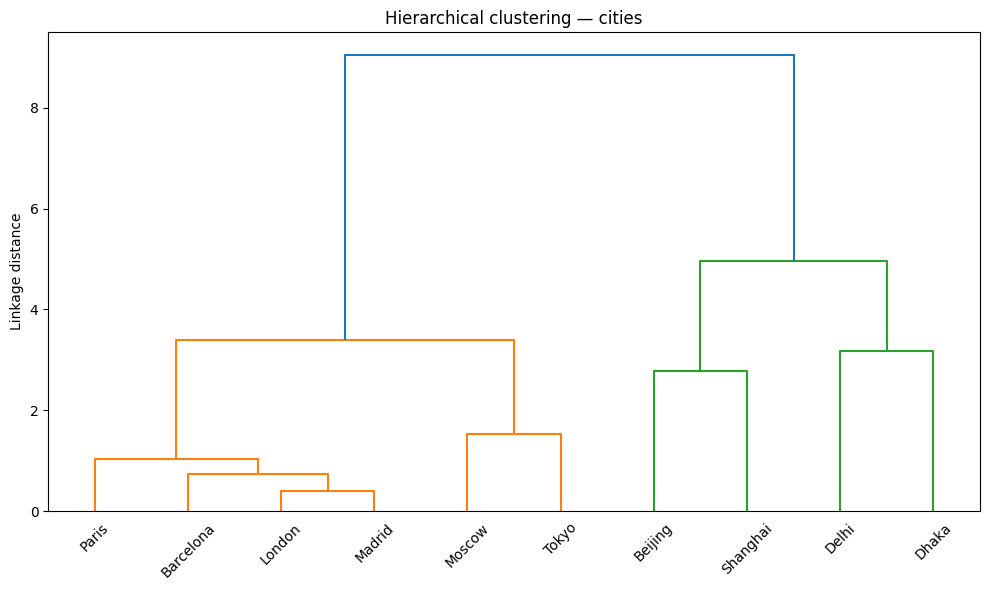

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane,cluster
city,,,,,,,,
Barcelona,21.677278,14.385553,201.976466,27.147944,470.886752,4.183639,1515.337912,1
Beijing,108.341138,75.294366,1302.999126,62.544712,528.908425,66.882944,2379.612332,2
Delhi,118.459887,68.909240,1069.667564,46.020609,473.523810,41.151593,1653.462149,2
Dhaka,70.797823,48.976398,619.268726,36.492148,466.781441,12.906757,2353.919414,2
London,14.110897,9.537358,187.557263,20.601173,474.952381,3.284765,1519.339438,1
Madrid,16.357929,9.654465,186.621558,20.843040,481.870574,3.682687,1467.325092,1
Moscow,28.788225,22.564930,344.664256,36.931041,481.507326,32.031728,1739.286325,1
Paris,16.667219,10.909786,204.889913,23.134675,490.637973,2.223148,1595.517705,1
Shanghai,69.138963,46.537692,1055.324785,63.593974,512.164835,60.725479,1734.468254,2


In [29]:
# Hierarchical on city-level pollutant means
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# load saved combined if you have it, otherwise build from files
try:
    combined = pd.read_csv("global_clusters_all_cities.csv", parse_dates=["datetime"])
except Exception:
    # fallback: load the six clean hourly files and concat (adjust paths if needed)
    files = {
        "Barcelona": "Barcelona_clean_hourly.csv",
        "Beijing": "Beijing_clean_hourly.csv",
        "Delhi":   "Delhi_clean_hourly.csv",
        "Dhaka":  "Dhaka_clean_hourly.csv",
        "London":  "London_clean_hourly.csv",
        "Madrid":  "Madrid_clean_hourly.csv",
        "Moscow":  "Moscow_clean_hourly.csv",
        "Paris": "Paris_clean_hourly.csv",
        "Shanghai": "Shanghai_clean_hourly.csv",
        "Tokyo": "Tokyo_clean_hourly.csv",
    }
    dfs = []
    for city, fn in files.items():
        try:
            df = pd.read_csv(fn, parse_dates=["datetime"])
            df["city"] = city
            dfs.append(df)
        except FileNotFoundError:
            pass
    combined = pd.concat(dfs, ignore_index=True)

# choose pollutant columns that exist
pollutants = [c for c in ["pm10","pm2_5","carbon_monoxide","nitrogen_dioxide",
                          "carbon_dioxide","sulphur_dioxide","methane"] if c in combined.columns]

# compute city means
df_city = combined.groupby("city")[pollutants].mean()
print("City means (used for hierarchical):")
display(df_city)

# clean & scale
dfc = df_city.replace([np.inf, -np.inf], np.nan).fillna(df_city.median())
X = StandardScaler().fit_transform(dfc.values)

# linkage & dendrogram
Z = linkage(X, method="ward")
plt.figure(figsize=(10,6)) # Increased figure size
dendrogram(Z, labels=dfc.index.tolist(), leaf_font_size=10, leaf_rotation=45) # Adjusted font size and added rotation
plt.title("Hierarchical clustering — cities")
plt.ylabel("Linkage distance")
plt.tight_layout() # Ensure labels fit
plt.show()

# optional cluster labels
from scipy.cluster.hierarchy import fcluster
labels = fcluster(Z, t=2, criterion="maxclust")
df_city["cluster"] = labels
display(df_city)

In [30]:
# Simple rule-based interpreter to generate short textual summaries per cluster
def interpret_cluster_means(row):
    texts = []
    # thresholds are coarse — adjust to your units/typical ranges if needed
    if "pm2_5" in row.index and (row["pm2_5"] > 40 or row.get("pm10",0) > 60):
        texts.append("High fine particulate (PM2.5/PM10) — haze/smoke or dust")
    if "nitrogen_dioxide" in row.index and row["nitrogen_dioxide"] > 40:
        texts.append("High NO₂ — traffic/combustion influence")
    if "carbon_monoxide" in row.index and row["carbon_monoxide"] > 5:
        texts.append("Elevated CO — combustion/vehicle emissions")
    if "sulphur_dioxide" in row.index and row["sulphur_dioxide"] > 10:
        texts.append("Elevated SO₂ — industrial/fuel combustion source")
    if "methane" in row.index and row["methane"] > 2000:
        texts.append("High CH₄ — methane sources (waste/agriculture/leaks)")
    if "carbon_dioxide" in row.index and row["carbon_dioxide"] > 450:
        texts.append("Elevated CO₂ — dense urban activity")
    if not texts:
        return "Low-to-moderate pollution (background)"
    return "; ".join(texts)

interpretations = {}
for cl in sorted(df_city["cluster"].unique()):
    profile = df_city[df_city["cluster"]==cl].drop(columns="cluster").mean()
    interpretations[cl] = interpret_cluster_means(profile)

# print nicely
for cl, text in interpretations.items():
    print(f"Cluster {cl}: {text}")


Cluster 1: Elevated CO — combustion/vehicle emissions; Elevated SO₂ — industrial/fuel combustion source; Elevated CO₂ — dense urban activity
Cluster 2: High fine particulate (PM2.5/PM10) — haze/smoke or dust; High NO₂ — traffic/combustion influence; Elevated CO — combustion/vehicle emissions; Elevated SO₂ — industrial/fuel combustion source; High CH₄ — methane sources (waste/agriculture/leaks); Elevated CO₂ — dense urban activity


Quick guide to interpretation & writing up
The dendrogram shows which cities are most similar and at what distance. Short branch = more similar pollutant fingerprints.

- df_city table (with cluster column) tells you each city’s assigned cluster — that’s your main Asia vs Europe mapping.

- Use the heatmap (z-scored) to report which pollutants are above or below the 10-city mean (positive z → higher than mean).

In report, include:

- a one-sentence cluster name (e.g., “Cluster 1 — PM‑dominated (haze)”) from CELL 5,

- a short paragraph per cluster describing likely sources (traffic, industry, biomass burning), and

- a city table showing percent of time (or number of hours) each city spends in each cluster (for hourly analyses you can compute percent-of-hours per cluster for each city; for city-means you just show assignment).